In [1]:
from transformer_lens import HookedTransformer
import torch
import matplotlib.pyplot as plt
import os

torch.set_grad_enabled(False)

model = HookedTransformer.from_pretrained("meta-llama/Meta-Llama-3-8B", device="cuda")

/usr/local/lib/python3.9/site-packages/transformers/utils/hub.py:127: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loaded pretrained model meta-llama/Meta-Llama-3-8B into HookedTransformer


In [2]:
print(model)

HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (blocks): ModuleList(
    (0-31): 32 x TransformerBlock(
      (ln1): RMSNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2): RMSNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (attn): GroupedQueryAttention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
        (hook_rot_k): HookPoint()
        (hook_rot_q): HookPoint()
      )
      (mlp): GatedMLP(
        (hook_pre): HookPoint()
        (hook_pre_linear): HookPoint()
        (hook_post): HookPoint()
      )
      (hook_attn_in): HookPoint()
      (hook_q_input): HookPoint()
      (hook_k_input): HookPoint()
      (hook_v_input): HookPoint()
      (hook_mlp_in): HookPoint()
      (hook_att

In [3]:
A = """
(28, 59)
(86, 175)
(13, 29)
(37, 77)
(55, 113)
(84, 171)
(66, 135)
(85, 173)
(27, 57)
(15, 33)
(94, 191)
(37, 77)
(14, 31)
(42, 87)
""" # 2x + 3

In [4]:
numbers = [str(i) for i in range(1, 205)]

number_tokens = model.to_tokens(numbers, prepend_bos=False).squeeze(1)

In [5]:
tokens = model.to_tokens(A)
text = model.tokenizer.convert_ids_to_tokens(tokens[0])
print(text)

W_U = model.unembed.W_U

['<|begin_of_text|>', 'Ċ', '(', '28', ',', 'Ġ', '59', ')Ċ', '(', '86', ',', 'Ġ', '175', ')Ċ', '(', '13', ',', 'Ġ', '29', ')Ċ', '(', '37', ',', 'Ġ', '77', ')Ċ', '(', '55', ',', 'Ġ', '113', ')Ċ', '(', '84', ',', 'Ġ', '171', ')Ċ', '(', '66', ',', 'Ġ', '135', ')Ċ', '(', '85', ',', 'Ġ', '173', ')Ċ', '(', '27', ',', 'Ġ', '57', ')Ċ', '(', '15', ',', 'Ġ', '33', ')Ċ', '(', '94', ',', 'Ġ', '191', ')Ċ', '(', '37', ',', 'Ġ', '77', ')Ċ', '(', '14', ',', 'Ġ', '31', ')Ċ', '(', '42', ',', 'Ġ', '87', ')Ċ']


In [6]:
logits, activations = model.run_with_cache(A, return_cache_object=False)

In [7]:
resid_post_activations = []

for key in activations.keys():
    if "resid_post" in key:
        resid_post_activations.append(activations[key].squeeze(0)[-3])
        print(resid_post_activations[-1].shape)

lensed_logits = []

for activation in resid_post_activations:
    lensed_logits.append(torch.matmul(activation, W_U))

torch.Size([4096])
torch.Size([4096])
torch.Size([4096])
torch.Size([4096])
torch.Size([4096])
torch.Size([4096])
torch.Size([4096])
torch.Size([4096])
torch.Size([4096])
torch.Size([4096])
torch.Size([4096])
torch.Size([4096])
torch.Size([4096])
torch.Size([4096])
torch.Size([4096])
torch.Size([4096])
torch.Size([4096])
torch.Size([4096])
torch.Size([4096])
torch.Size([4096])
torch.Size([4096])
torch.Size([4096])
torch.Size([4096])
torch.Size([4096])
torch.Size([4096])
torch.Size([4096])
torch.Size([4096])
torch.Size([4096])
torch.Size([4096])
torch.Size([4096])
torch.Size([4096])
torch.Size([4096])


In [8]:
for logit in lensed_logits:
    logit = torch.softmax(logit, dim=-1)
    topk = torch.topk(logit, 20)
    predicted_text = model.tokenizer.convert_ids_to_tokens(topk.indices)
    print(predicted_text)
    print(topk.values)

['ãĥªãĤ¢', 'ĠComet', 'ASN', 'opher', 'ibo', 'ĠFIX', 'ĠGriffin', 'ĠMariners', 'ÛĮØ±Ùĩ', 'nÄĽm', 'ĠMelee', 'ĠPRI', 'implify', 'Ġbinge', 'âĢĤ', 'ĠWA', 'ç§¯', 'ĠTou', 'á»ĭnh', 'apus']
tensor([8.5663e-06, 8.5511e-06, 8.5455e-06, 8.5294e-06, 8.5031e-06, 8.4747e-06,
        8.4737e-06, 8.4594e-06, 8.4590e-06, 8.4513e-06, 8.4496e-06, 8.4369e-06,
        8.4359e-06, 8.4345e-06, 8.4342e-06, 8.4302e-06, 8.4245e-06, 8.4240e-06,
        8.4237e-06, 8.4221e-06], device='cuda:0', grad_fn=<TopkBackward0>)
['implify', 'Ð¾ÑĢÐ°Ñı', 'ëĶ°', '.liferay', '_CSS', 'Ø§Ø³Ùĩ', 'Ġsemiclass', 'ĠBanc', 'ãģ¤ãģĳ', 'ÎµÏĦ', 'pra', 'ĠCann', 'avir', 'opher', 'ĠDante', 'ļĮ', 'Concat', 'NAMESPACE', 'rou', 'Ġ;čĊ']
tensor([9.2203e-06, 9.0069e-06, 8.9715e-06, 8.9666e-06, 8.9565e-06, 8.9500e-06,
        8.9362e-06, 8.8981e-06, 8.8968e-06, 8.8955e-06, 8.8913e-06, 8.8887e-06,
        8.8684e-06, 8.8661e-06, 8.8507e-06, 8.8491e-06, 8.8390e-06, 8.8377e-06,
        8.8313e-06, 8.8245e-06], device='cuda:0', grad_fn=<TopkBackward0>)
[

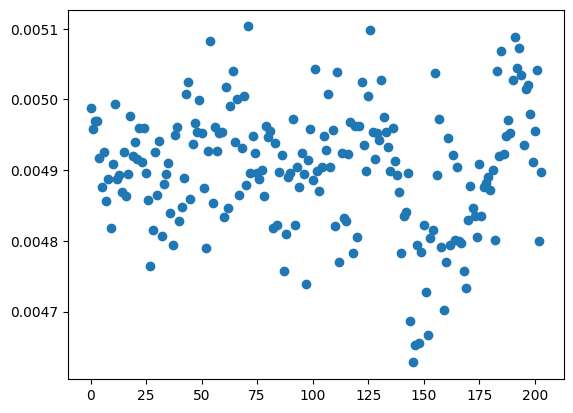

tensor([0.0049], device='cuda:0', grad_fn=<IndexBackward0>)
['72', '127', '192', '55', '194']


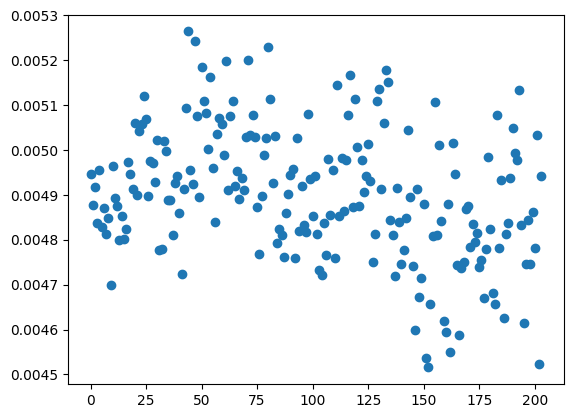

tensor([0.0048], device='cuda:0', grad_fn=<IndexBackward0>)
['45', '48', '81', '72', '62']


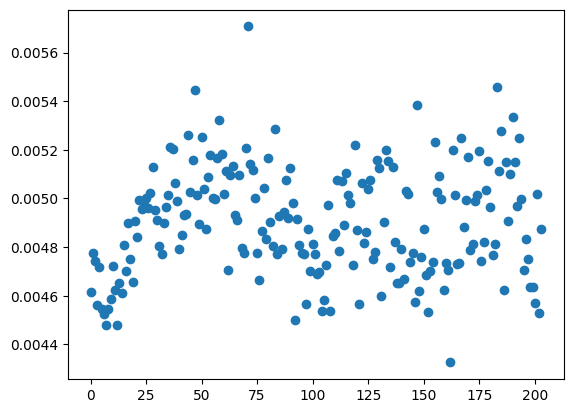

tensor([0.0048], device='cuda:0', grad_fn=<IndexBackward0>)
['72', '184', '48', '148', '191']


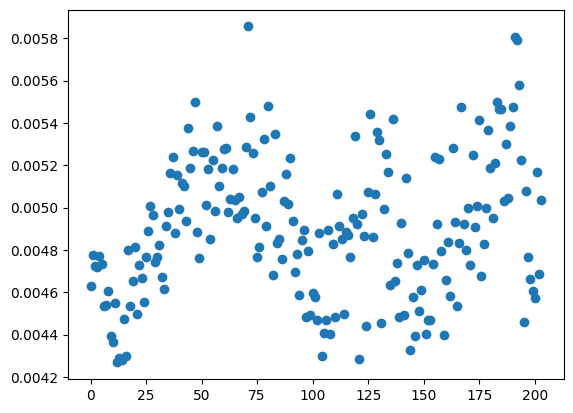

tensor([0.0048], device='cuda:0', grad_fn=<IndexBackward0>)
['72', '192', '193', '194', '184']


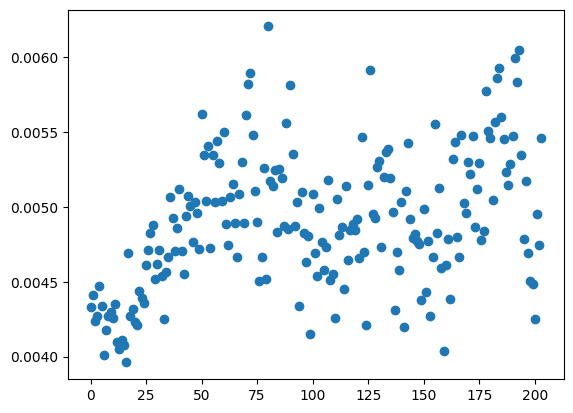

tensor([0.0052], device='cuda:0', grad_fn=<IndexBackward0>)
['81', '194', '192', '185', '127']


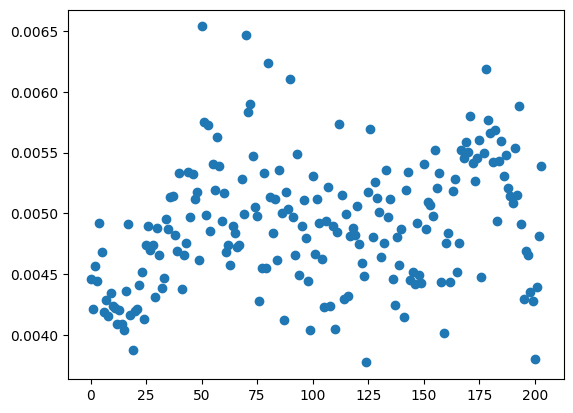

tensor([0.0050], device='cuda:0', grad_fn=<IndexBackward0>)
['51', '71', '81', '179', '91']


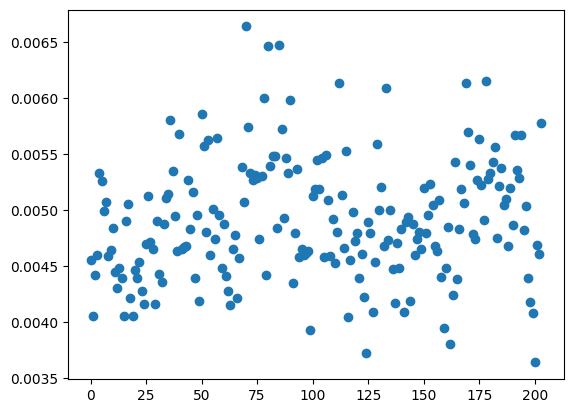

tensor([0.0057], device='cuda:0', grad_fn=<IndexBackward0>)
['71', '86', '81', '179', '113']


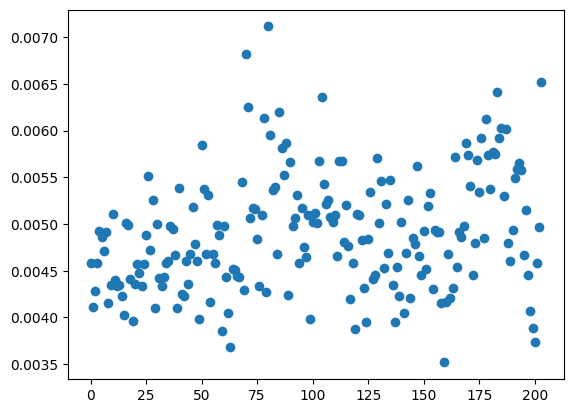

tensor([0.0058], device='cuda:0', grad_fn=<IndexBackward0>)
['81', '71', '204', '184', '105']


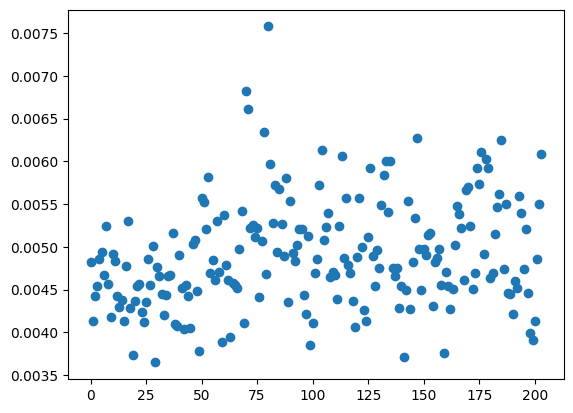

tensor([0.0053], device='cuda:0', grad_fn=<IndexBackward0>)
['81', '71', '72', '79', '148']


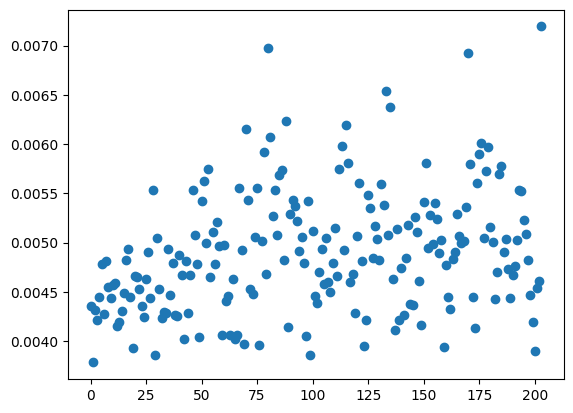

tensor([0.0057], device='cuda:0', grad_fn=<IndexBackward0>)
['204', '81', '171', '134', '136']


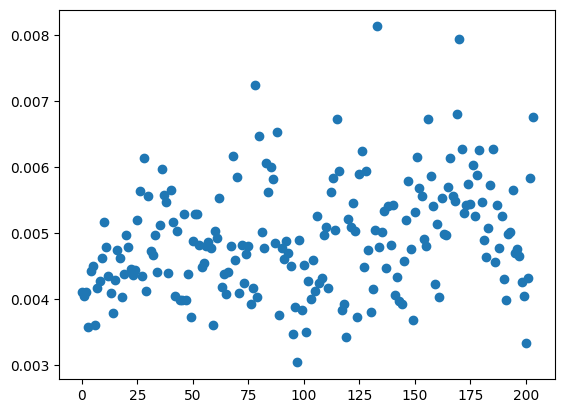

tensor([0.0058], device='cuda:0', grad_fn=<IndexBackward0>)
['134', '171', '79', '170', '204']


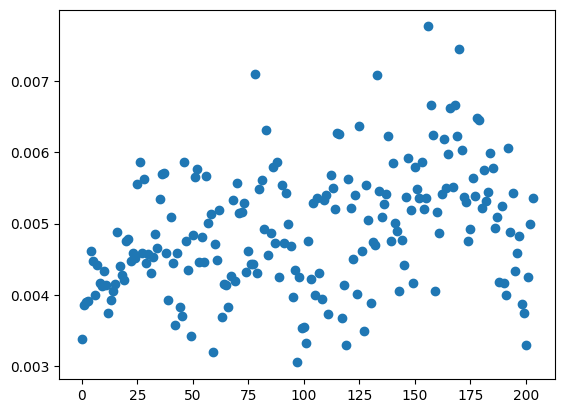

tensor([0.0058], device='cuda:0', grad_fn=<IndexBackward0>)
['157', '171', '79', '134', '169']


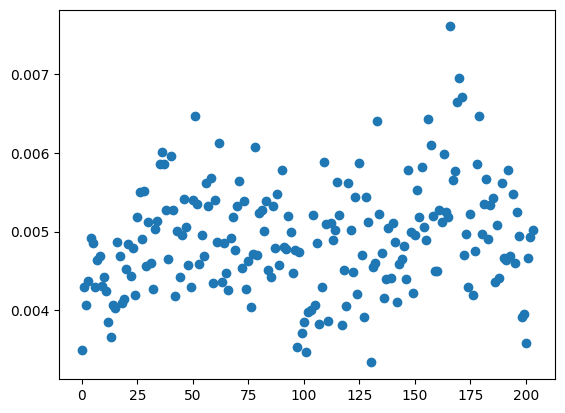

tensor([0.0053], device='cuda:0', grad_fn=<IndexBackward0>)
['167', '171', '172', '170', '180']


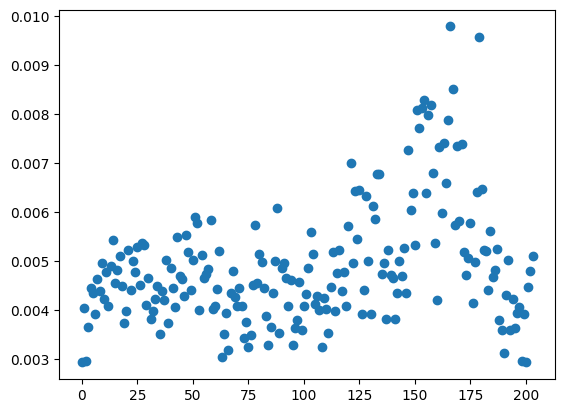

tensor([0.0043], device='cuda:0', grad_fn=<IndexBackward0>)
['167', '180', '168', '155', '158']


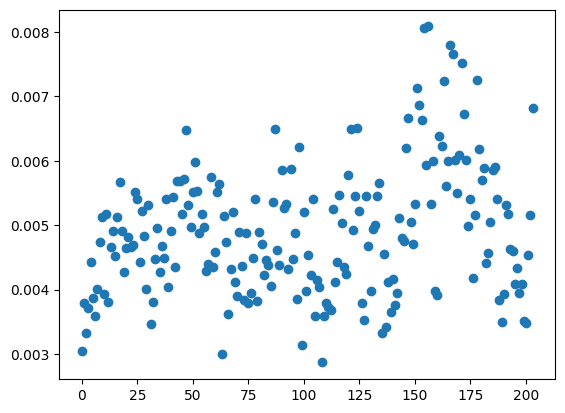

tensor([0.0054], device='cuda:0', grad_fn=<IndexBackward0>)
['157', '155', '167', '168', '172']


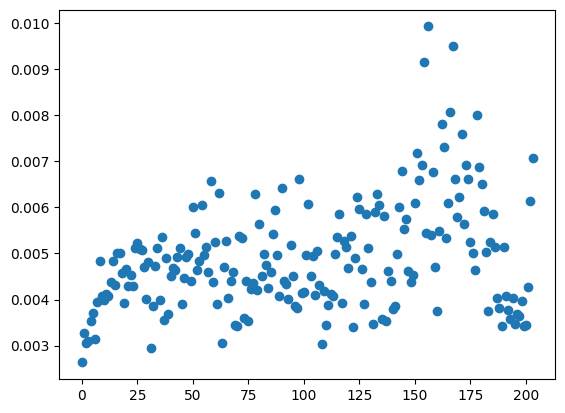

tensor([0.0054], device='cuda:0', grad_fn=<IndexBackward0>)
['157', '168', '155', '167', '179']


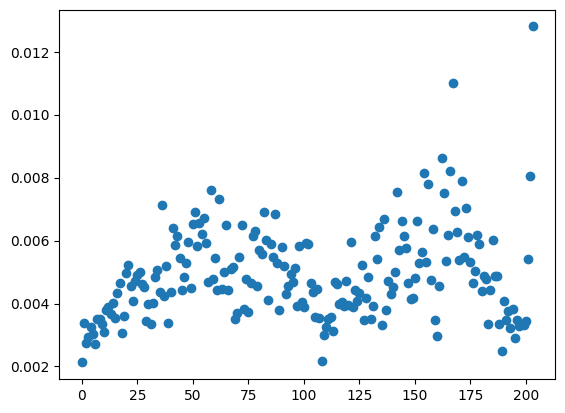

tensor([0.0055], device='cuda:0', grad_fn=<IndexBackward0>)
['204', '168', '163', '167', '155']


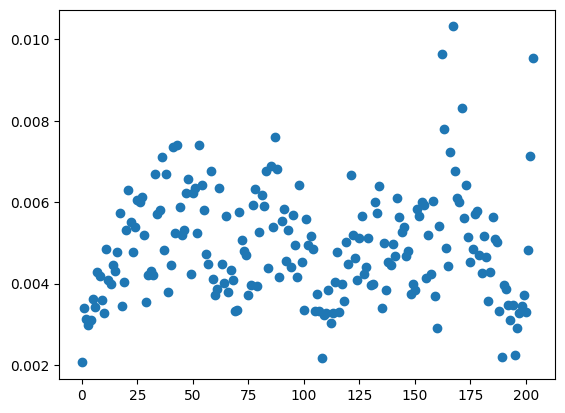

tensor([0.0054], device='cuda:0', grad_fn=<IndexBackward0>)
['168', '163', '204', '172', '164']


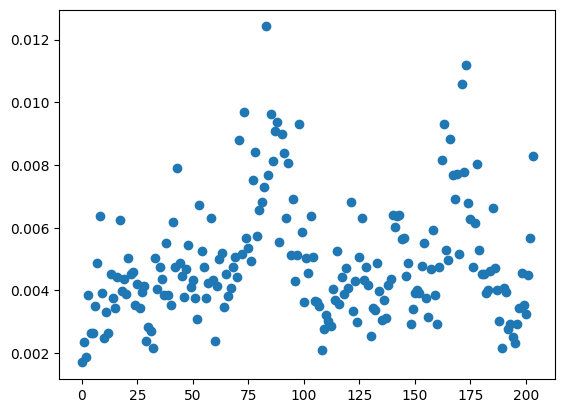

tensor([0.0081], device='cuda:0', grad_fn=<IndexBackward0>)
['84', '174', '172', '74', '86']


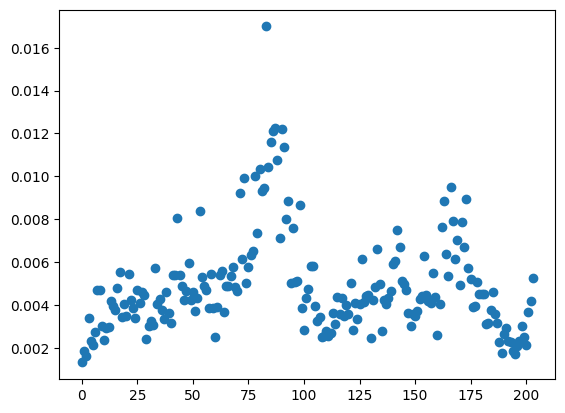

tensor([0.0121], device='cuda:0', grad_fn=<IndexBackward0>)
['84', '88', '91', '87', '86']


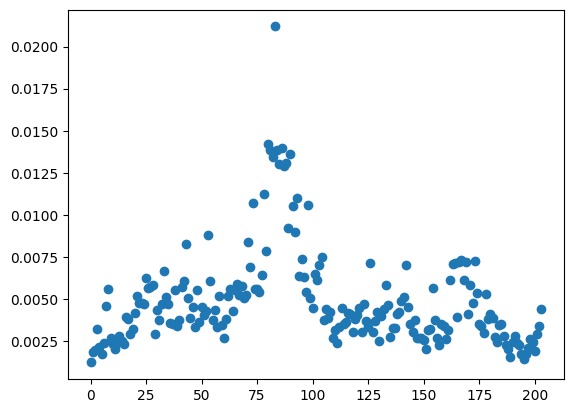

tensor([0.0140], device='cuda:0', grad_fn=<IndexBackward0>)
['84', '81', '87', '85', '82']


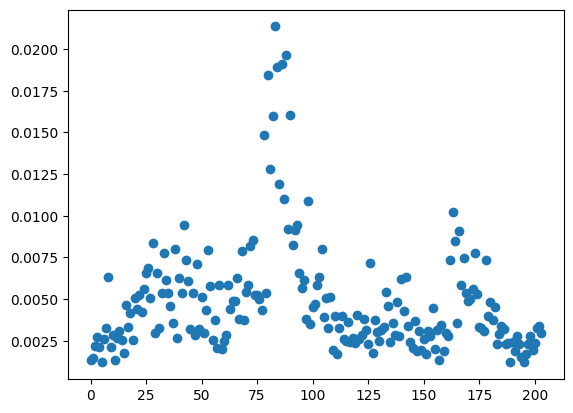

tensor([0.0191], device='cuda:0', grad_fn=<IndexBackward0>)
['84', '89', '87', '85', '81']


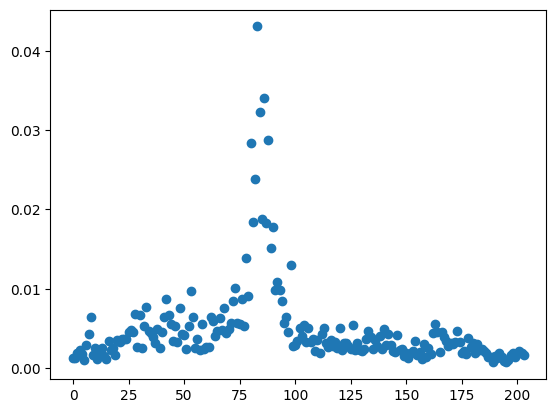

tensor([0.0340], device='cuda:0', grad_fn=<IndexBackward0>)
['84', '87', '85', '89', '81']


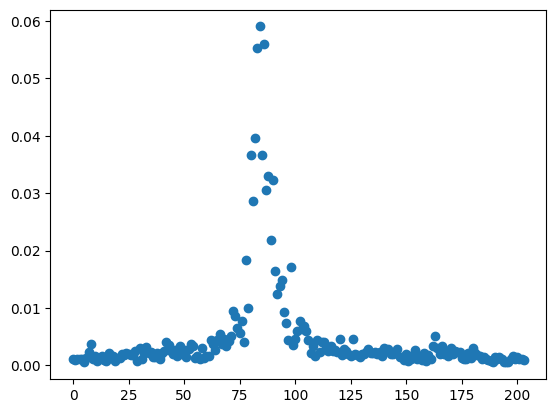

tensor([0.0560], device='cuda:0', grad_fn=<IndexBackward0>)
['85', '87', '84', '83', '81']


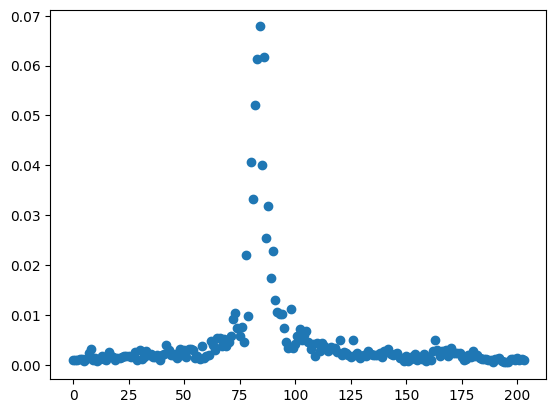

tensor([0.0617], device='cuda:0', grad_fn=<IndexBackward0>)
['85', '87', '84', '83', '81']


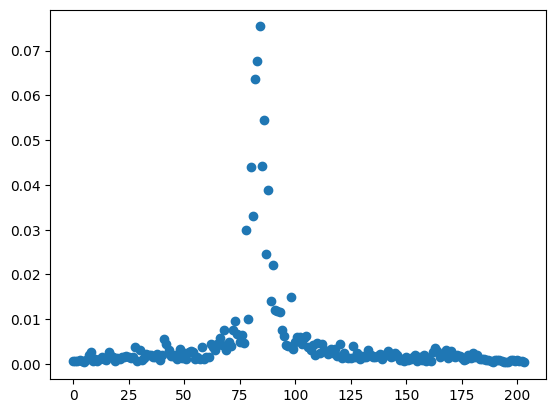

tensor([0.0544], device='cuda:0', grad_fn=<IndexBackward0>)
['85', '84', '83', '87', '86']


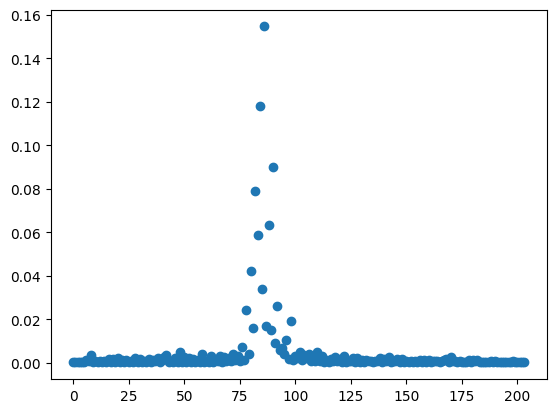

tensor([0.1545], device='cuda:0', grad_fn=<IndexBackward0>)
['87', '85', '91', '83', '89']


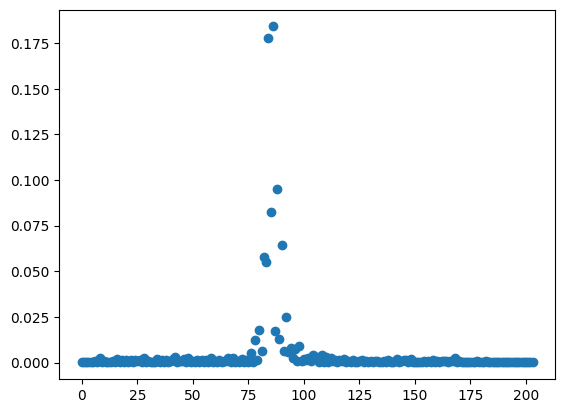

tensor([0.1841], device='cuda:0', grad_fn=<IndexBackward0>)
['87', '85', '89', '86', '91']


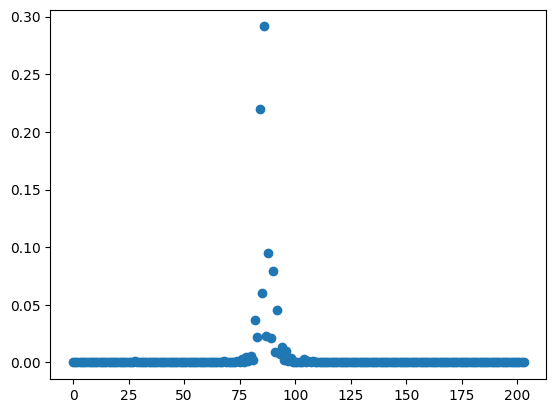

tensor([0.2914], device='cuda:0', grad_fn=<IndexBackward0>)
['87', '85', '89', '91', '86']


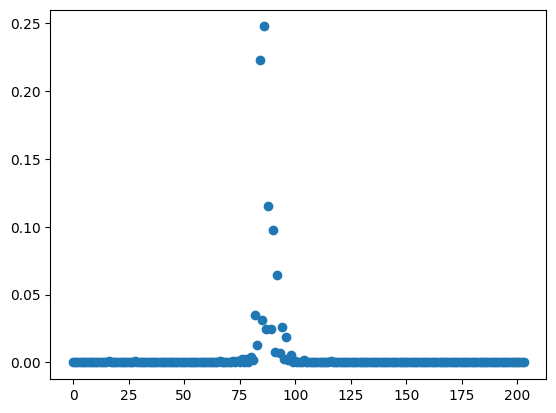

tensor([0.2476], device='cuda:0', grad_fn=<IndexBackward0>)
['87', '85', '89', '91', '93']


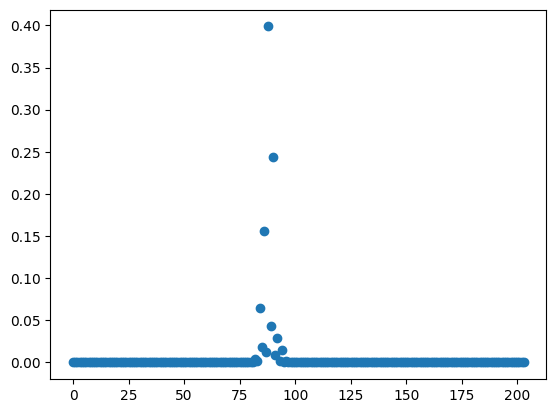

tensor([0.1560], device='cuda:0', grad_fn=<IndexBackward0>)
['89', '91', '87', '85', '90']


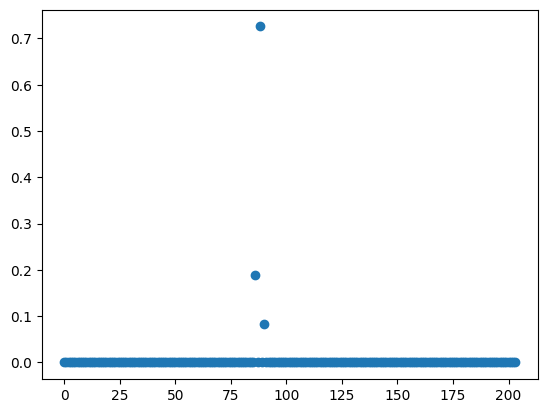

tensor([0.1897], device='cuda:0', grad_fn=<IndexBackward0>)
['89', '87', '91', '85', '93']


In [9]:
eighty_seven_token = model.to_tokens("87", prepend_bos=False).squeeze(0)


for logit in lensed_logits:
    x = logit.clone()
    
    # Set everything except for number_tokens to negative infinity
    negative_inf = float('-inf')
    mask = torch.ones_like(x, dtype=torch.bool)
    mask[number_tokens] = False
    x[mask] = negative_inf

    x_softmaxed = torch.softmax(x, dim=-1)
    plt.scatter(list(range(len(number_tokens))), x_softmaxed[number_tokens].detach().cpu().numpy())
    plt.show()
    print(x_softmaxed[eighty_seven_token])

    topk = torch.topk(x, 5)
    predicted_text = model.tokenizer.convert_ids_to_tokens(topk.indices)
    print(predicted_text)

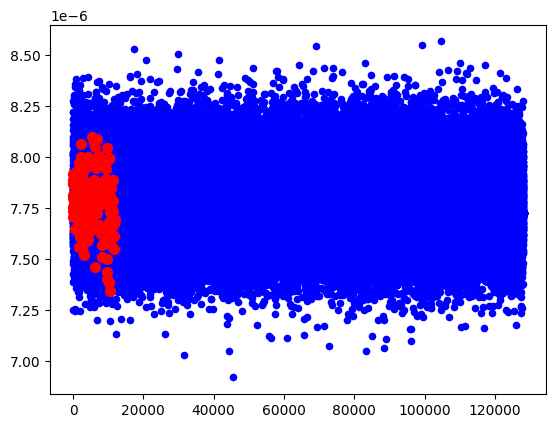

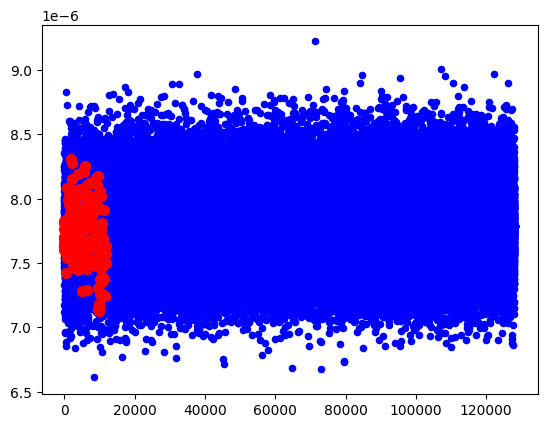

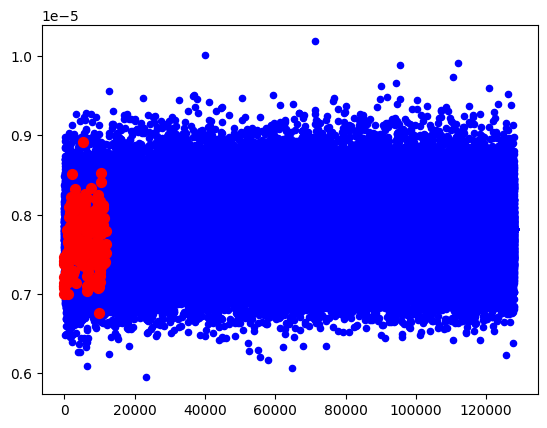

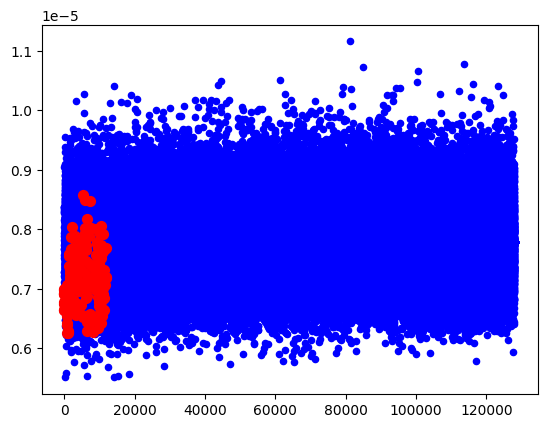

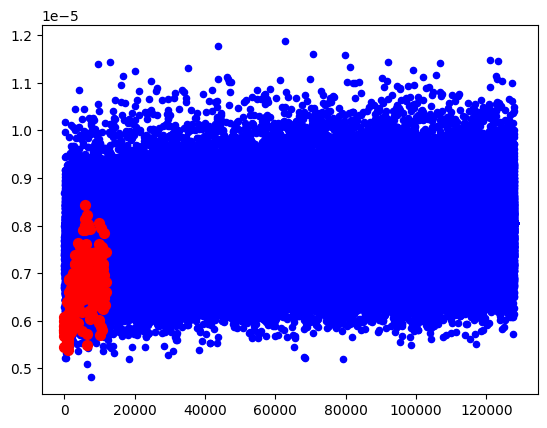

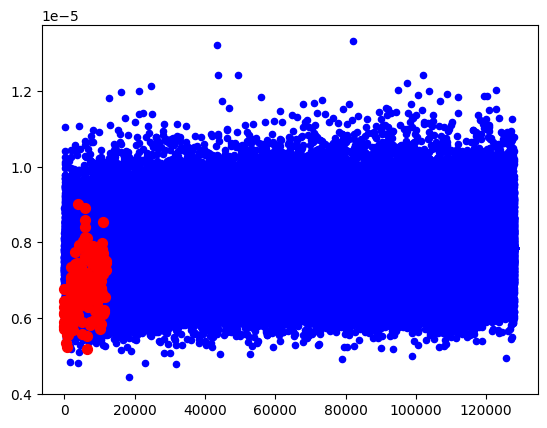

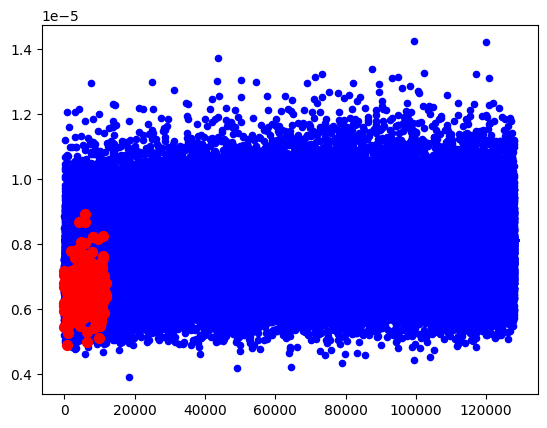

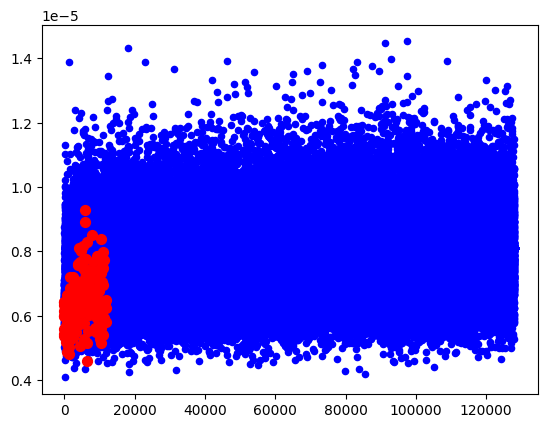

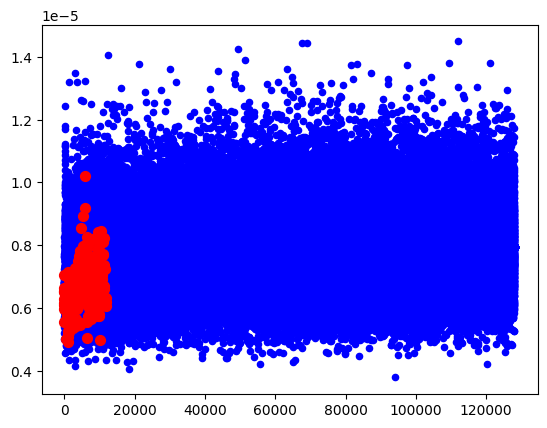

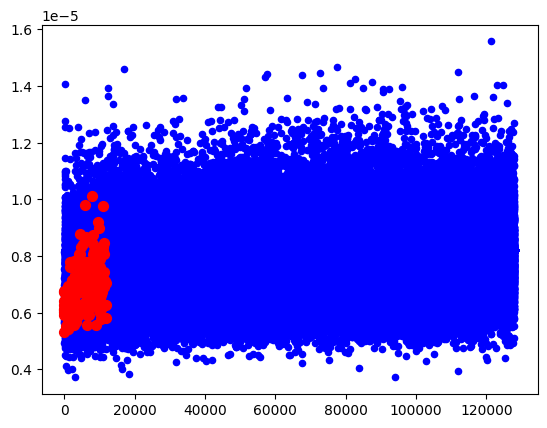

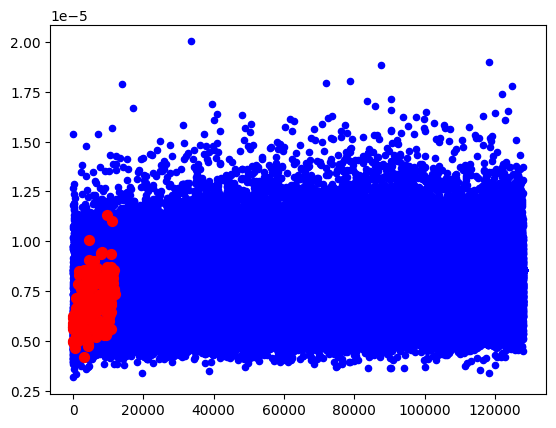

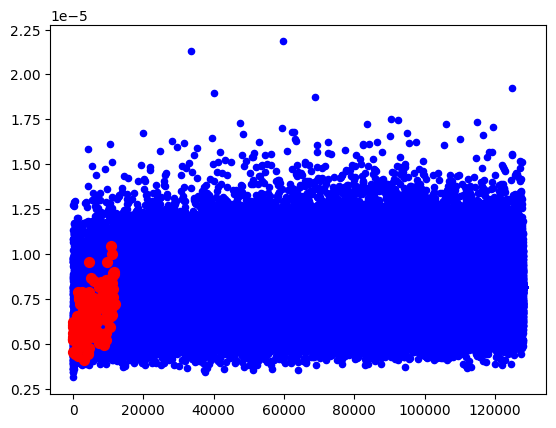

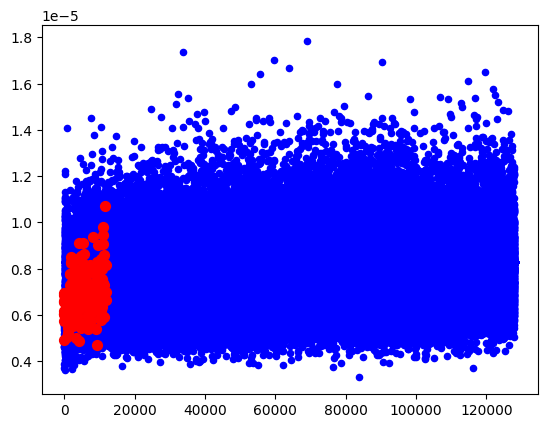

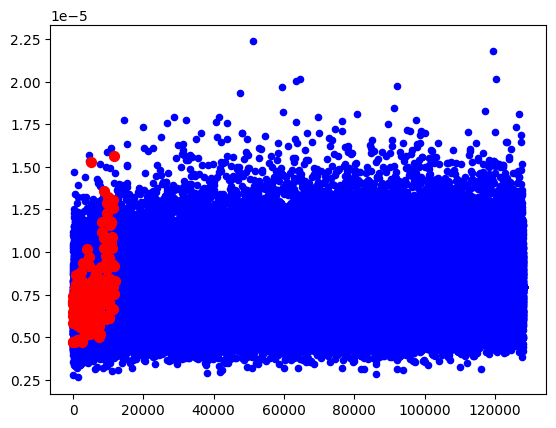

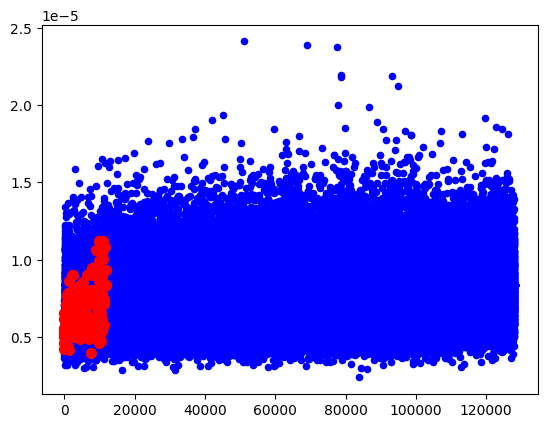

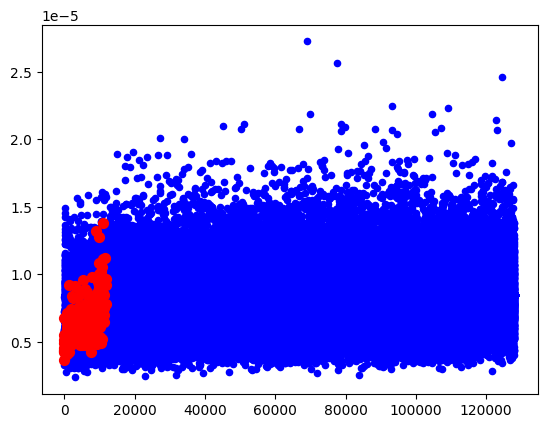

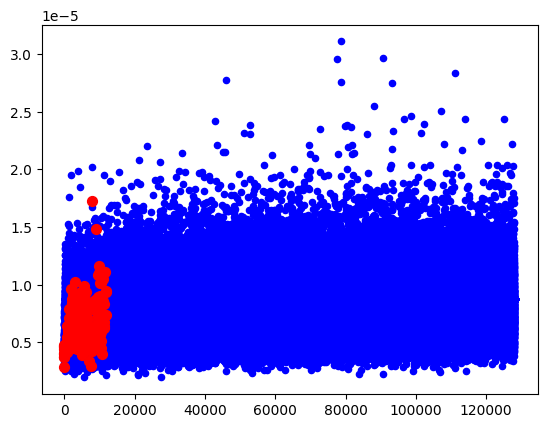

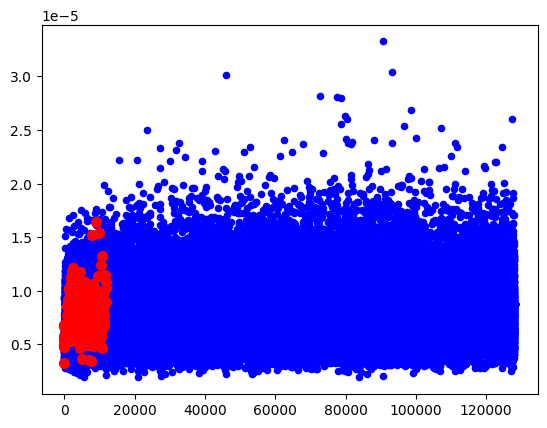

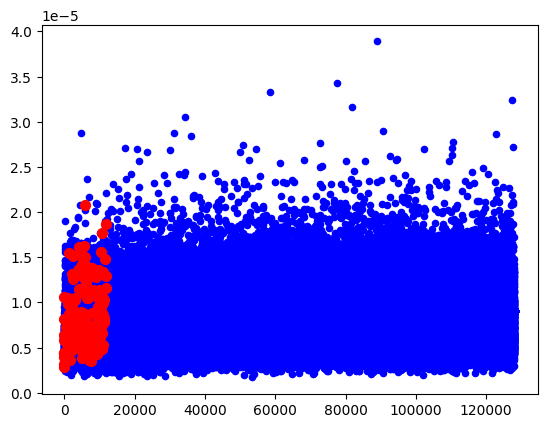

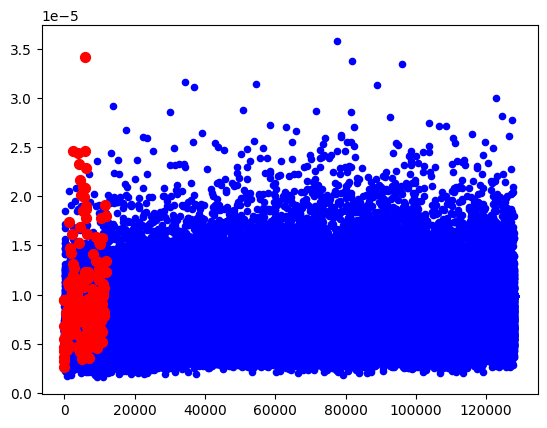

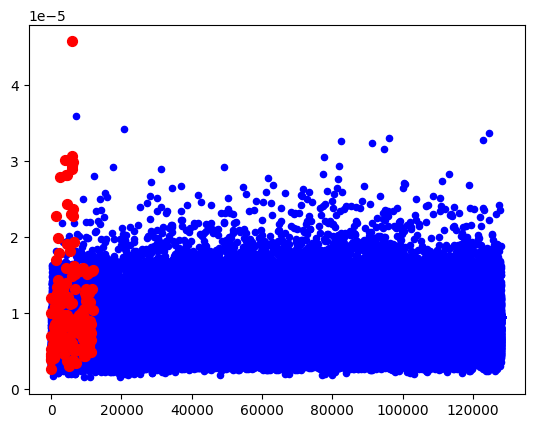

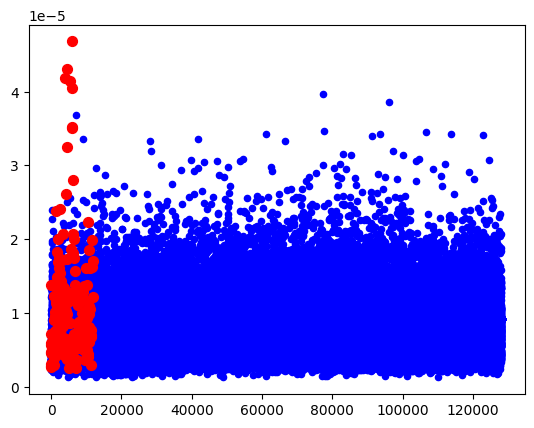

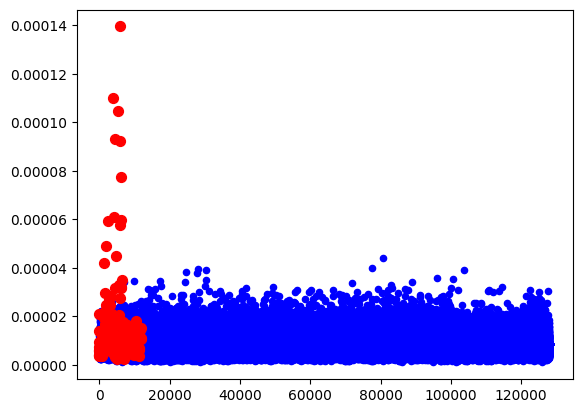

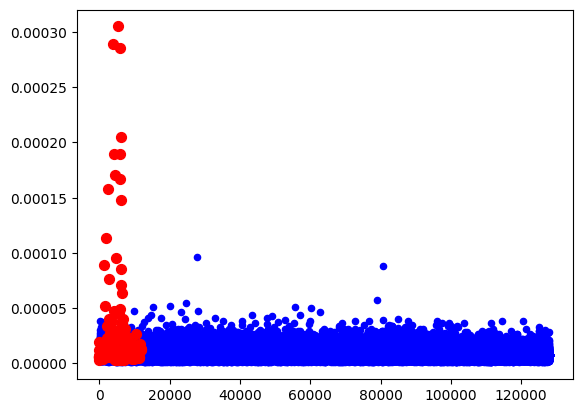

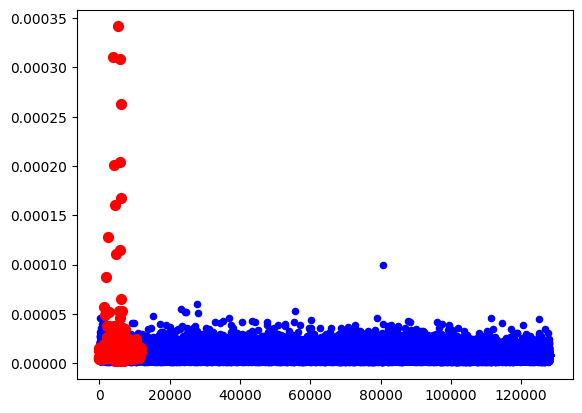

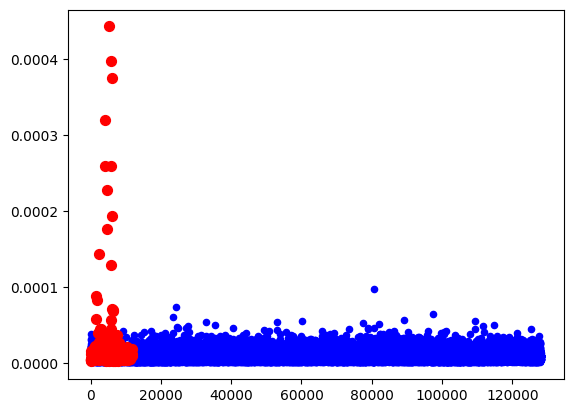

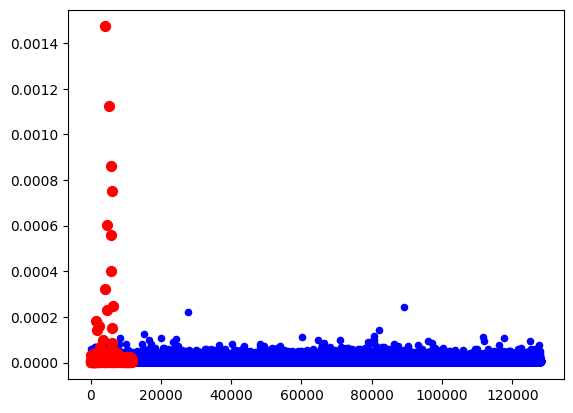

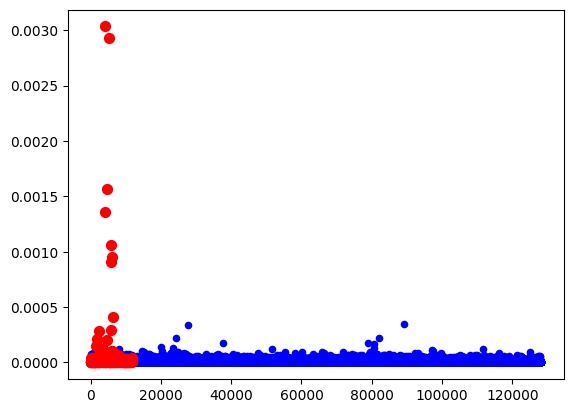

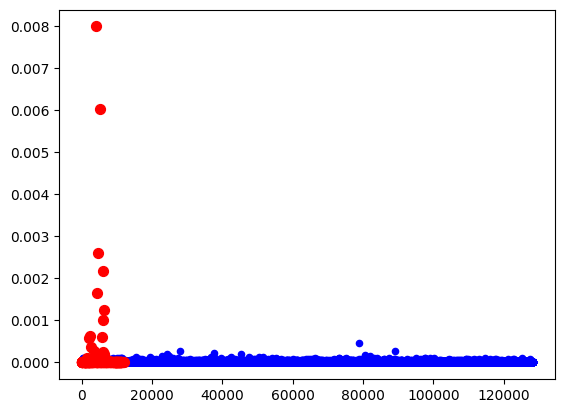

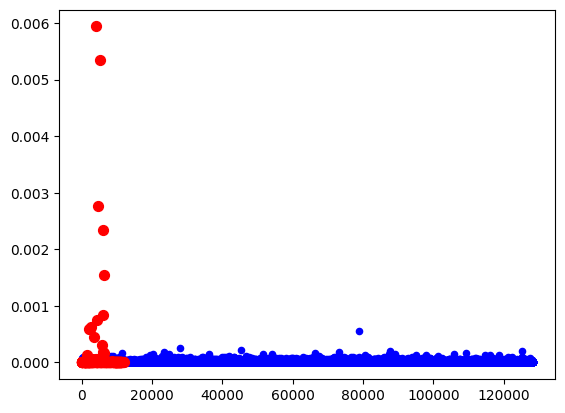

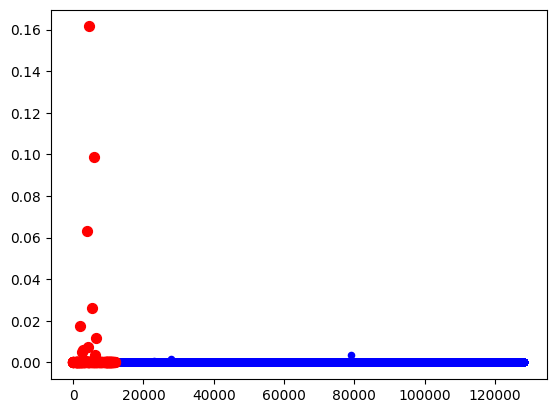

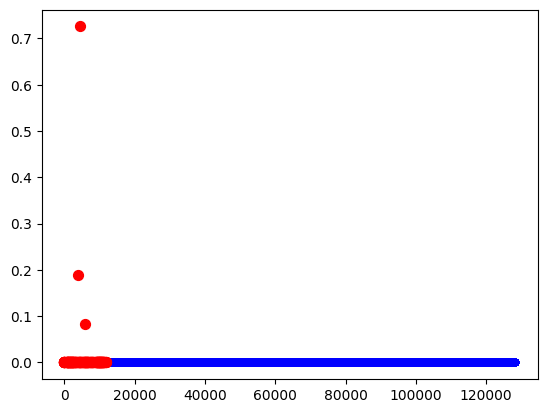

In [15]:

# Determine colors and sizes
colors = ['red' if i in number_tokens else 'blue' for i in range(len(lensed_logits[0]))]
sizes = [50 if i in number_tokens else 20 for i in range(len(lensed_logits[0]))]  # Adjust sizes

# Separate indices for red and blue points
red_indices = [i for i, color in enumerate(colors) if color == 'red']
blue_indices = [i for i, color in enumerate(colors) if color == 'blue']

for logit in lensed_logits:
    x_softmaxed = torch.softmax(logit, dim=-1)

    
    # Plot blue points first
    plt.scatter(blue_indices, x_softmaxed.detach().cpu().numpy()[blue_indices], c='blue', s=20)
    
    # Plot red points on top
    plt.scatter(red_indices, x_softmaxed.detach().cpu().numpy()[red_indices], c='red', s=50)
    
    plt.show()